## Exercise - Model Estimation & Evaluation

This is an exercise on parametric model estimation & model evaluation using a Wines dataset.

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.tight_layout()
import seaborn as sns
sns.set()

from scipy.stats import norm
from scipy.stats import kstest

<Figure size 432x288 with 0 Axes>

### Read from CSV File & Preliminary EDA

After reading from the CSV file, perform EDA for `points` and `price`.

In [2]:
wines_df = pd.read_csv('winemag-sample.csv')
print(wines_df[['variety', 'country', 'points', 'price']].sample(3))

        variety country  points  price
144        Rosé  France      84    9.0
920  Chardonnay      US      91   45.0
749    Albariño      US      88   28.0


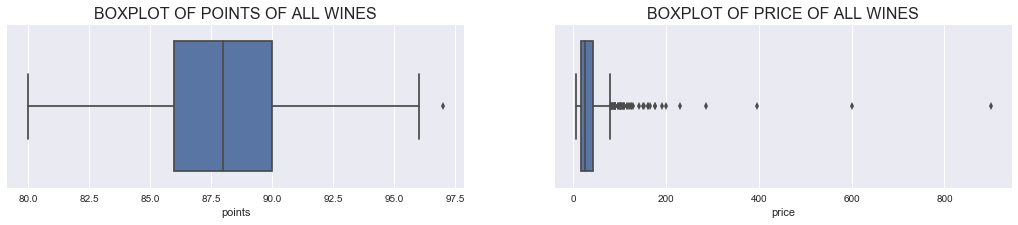

In [3]:
fig = plt.figure(figsize=(18, 3))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
sns.boxplot(wines_df['points'], ax=ax1)
ax1.set_title("BOXPLOT OF POINTS OF ALL WINES", fontsize=16)
sns.boxplot(wines_df['price'], ax=ax2)
ax2.set_title("BOXPLOT OF PRICE OF ALL WINES", fontsize=16)
plt.show()

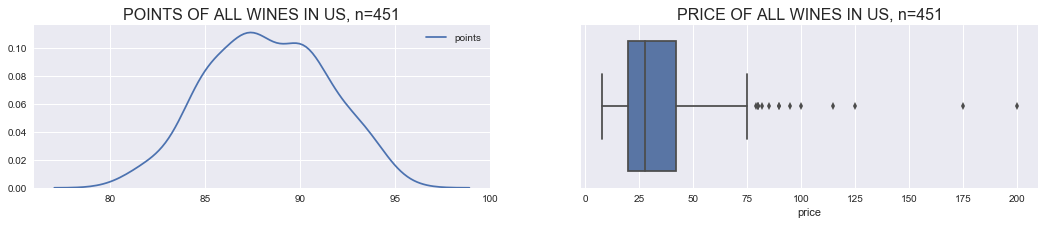

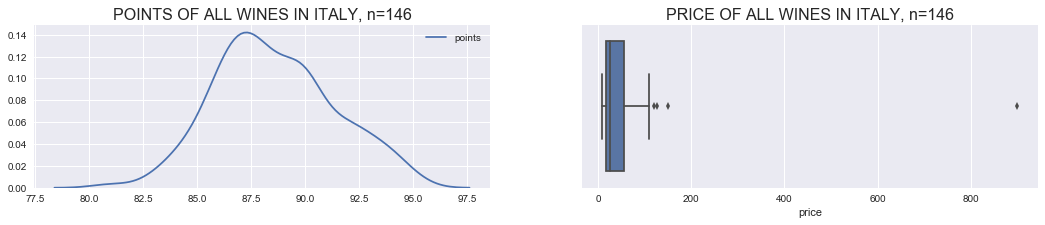

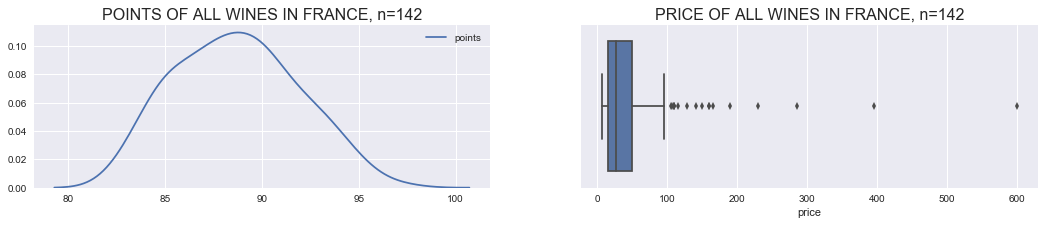

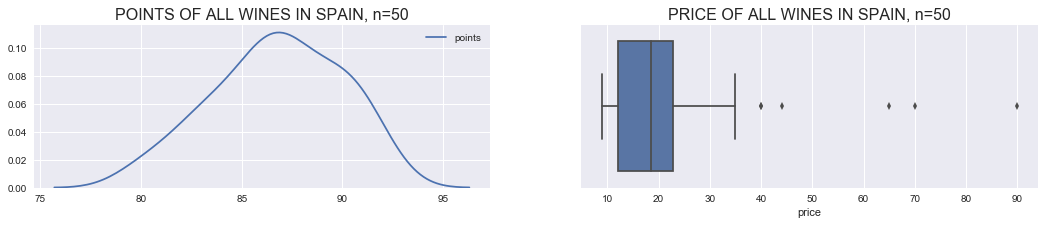

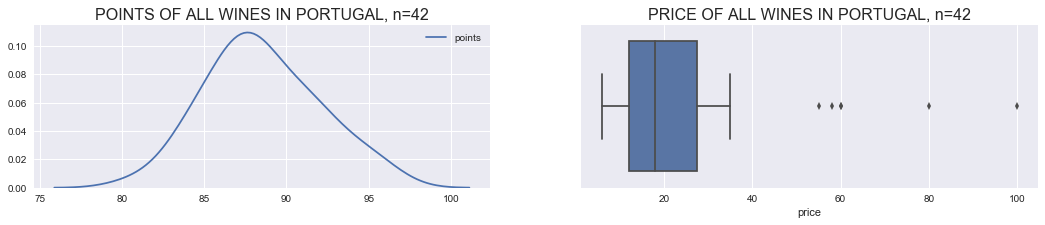

In [4]:
# Find top 5 wine producing countries.
top_countries = wines_df.groupby('country').size().reset_index(name='n').sort_values('n', ascending=False)[:5]['country'].tolist()
for c in top_countries:
    c_df = wines_df[wines_df.country == c]
    fig = plt.figure(figsize=(18, 3))
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
    sns.kdeplot(c_df['points'], ax=ax1)
    ax1.set_title("POINTS OF ALL WINES IN %s, n=%d" % (c.upper(), c_df.shape[0]), fontsize=16)
    sns.boxplot(c_df['price'], ax=ax2)
    ax2.set_title("PRICE OF ALL WINES IN %s, n=%d" % (c.upper(), c_df.shape[0]), fontsize=16)
    plt.show()

### Model Fitting (Parametric Estimation)

Let's take a look at the wines from the US. For ease of use, we sort them from the lowest to the highest.

In [5]:
us_wines_df = wines_df.copy()
us_wines_df = us_wines_df[us_wines_df.country == 'US']
us_wines_df.reset_index(drop=True, inplace=True)
us_wines_points = us_wines_df['points']
sorted_us_wines_points = us_wines_points.sort_values(ascending=True)

Let's attempt to fit the points of US wines to a normal distribution.

In [6]:
fitted_mu, fitted_sigma = norm.fit(us_wines_points)
print(fitted_mu,fitted_sigma**2)
print(us_wines_points.mean(),us_wines_points.var())

88.2749445676275 9.74702189271439
88.2749445676275 9.768681941364868


For US Wines points, we now know that $\hat{\mu}=88.275$ and $\hat{\sigma}^2=9.747$. Let's see what the histogram and the fitted line looks like.

In [7]:
# To plot the fitted, use norm.pdf to get the curve.
points_min, points_max = us_wines_points.min(), us_wines_points.max()
points_x = np.linspace(points_min-2, points_max+2, 100)
fitted_pdf = norm.pdf(points_x, fitted_mu, fitted_sigma)
fitted_cdf = norm.cdf(points_x, fitted_mu, fitted_sigma)
fitted_df = pd.DataFrame({'x' : points_x, 
                          'p_hat' : fitted_pdf,
                          'F_hat' : fitted_cdf})
print(fitted_df.head(3))

      F_hat     p_hat         x
0  0.000499  0.000568  78.00000
1  0.000627  0.000702  78.20202
2  0.000784  0.000863  78.40404


/Users/bryanlim/.pyenv/versions/3.4.8/envs/ds-toolkit/lib/python3.4/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


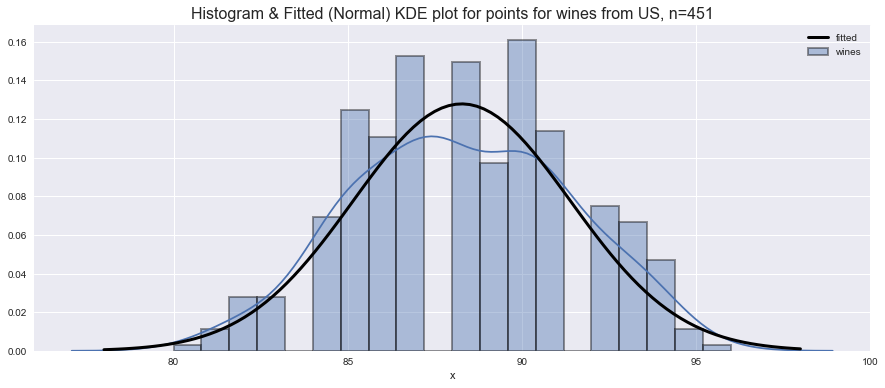

In [8]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)

# Plot the histogram of the empirical distribution
sns.distplot(us_wines_points, bins=20, hist_kws=dict(edgecolor="k", linewidth=2), ax=ax)
# Plot the fitted normal distribution
fitted_df.plot(kind='line', x='x', y='p_hat', linewidth=3, color='black', ax=ax)

ax.set_title("Histogram & Fitted (Normal) KDE plot for points for wines from US, n=%d" % us_wines_points.count(), fontsize=16)
ax.legend(['fitted', 'wines',])
plt.show()

### Model Evaluation - Graphical Methods
Now, we know that the fitted is a fair approximation to the empirical. Let's look at the CDF plots for both the empirical distribution and fitted distribution.

In [9]:
empirical_df = pd.DataFrame({'x' : sorted_us_wines_points})
empirical_df.reset_index(inplace=True, drop=True)
empirical_df['i'] = empirical_df.index+1
# For each value of x, find p(X<=x), stored as empirical_p
print('empirical_df.count()=%d' % empirical_df['x'].count())
print('empirical_df[\'x\'].nunique()=%d' % empirical_df['x'].nunique())
print('empirical_df[\'x\'].unique()=%s' % str(empirical_df['x'].unique().tolist()))
empirical_groupby_df = empirical_df.groupby('x')['i'].max().reset_index(name='cum_count')
empirical_groupby_df['F_empirical'] = empirical_groupby_df['cum_count']/empirical_groupby_df['cum_count'].max()

empirical_groupby_df2 = empirical_groupby_df.copy()
# empirical_groupby_df2 = empirical_groupby_df2[:-1]
empirical_groupby_df2['x'] = empirical_groupby_df2['x'].shift(-1)
empirical_groupby_df2 = empirical_groupby_df2[:-1]

empirical_groupby_df = empirical_groupby_df.append(empirical_groupby_df2)
empirical_groupby_df.sort_values(['x', 'F_empirical'], inplace=True)
print(empirical_groupby_df.head())

empirical_df.count()=451
empirical_df['x'].nunique()=17
empirical_df['x'].unique()=[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]
      x  cum_count  F_empirical
0  80.0          1     0.002217
0  81.0          1     0.002217
1  81.0          5     0.011086
1  82.0          5     0.011086
2  82.0         15     0.033259


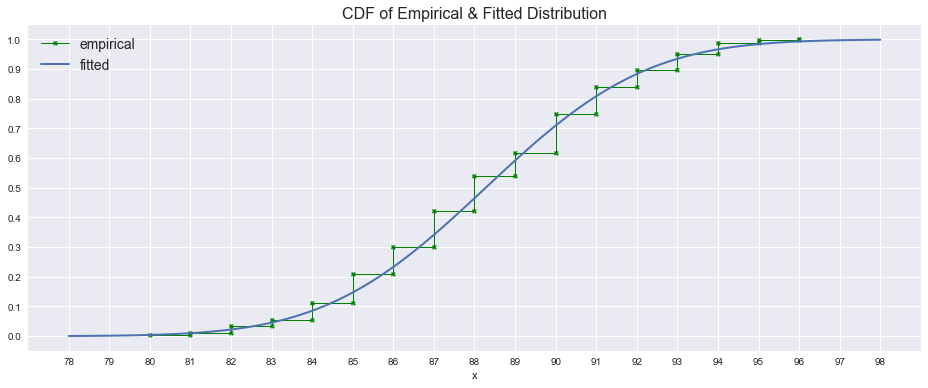

In [10]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)
empirical_groupby_df.plot(kind='line', x='x', y='F_empirical', marker='X', ax=ax, markersize=5, linewidth=1, color='green')
fitted_df.plot(kind='line', x='x', y='F_hat', marker='x', ax=ax, linewidth=2)
ax.set_title("CDF of Empirical & Fitted Distribution", fontsize=16)
ax.legend(['empirical', 'fitted'], fontsize=14)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(empirical_groupby_df['x'].min()-2,
                       empirical_groupby_df['x'].max()+3))
plt.show()

**Conclusion**: From the CDF plots, the distribution is a fairly good fit, but some clear deviations from the fitted can be seen where $86 \leq x \leq 90$. Hence, we should use other methods to evaluate the validity of the model.

### Graphical Methods - *p-p* Plot

A *p-p* plot or probability-probability plot is used to see the closeness of each value of $F(\cdot)$. On the $x$-axis is the empirical $F^*(\cdot)$ while on the $y$-axis is the fitted $\hat F(\cdot)$. 

To plot the *p-p* plot, first find the empirical distribution, $F^*(\cdot)$ of the sample. This is slightly different from that of the CDF curve. Find all unique point values of $x$ and sort them such that you get $(x_{(1)} \leq x_{(2)} \leq \cdots x_{(m)})$ for $m$ unique values. Then, for each value of $x_{(j)}$, $j \in \{x_{(1)}, \cdots, x_{(m)}\}$, approximate the probability of an observation less than or equal to $x_{(j)}$ using the sample proportion $F_j = \frac{i}{n+1}$.

In this exercise, $n=451$, $m=17$.

In [11]:
empirical_groupby_df['F_i'] = empirical_groupby_df['cum_count']/(empirical_groupby_df['cum_count'].max()+1)

In [12]:
empirical_groupby_df.head()

,x,cum_count,F_empirical,F_i
0,80.0,1,0.002217,0.002212
0,81.0,1,0.002217,0.002212
1,81.0,5,0.011086,0.011062
1,82.0,5,0.011086,0.011062
2,82.0,15,0.033259,0.033186


In [13]:
min_prob = empirical_groupby_df.groupby('x')['F_i'].min().reset_index(name='F_i')
max_prob = empirical_groupby_df.groupby('x')['F_i'].max().reset_index(name='F_i')
pp_df = min_prob.append(max_prob).sort_values(['x', 'F_i'])
pp_df.drop_duplicates(subset=['x', 'F_i'], inplace=True)
pp_df['p_fitted'] = norm.cdf(pp_df['x'], fitted_mu, fitted_sigma)
print(pp_df.head())
print(pp_df.tail())

      x       F_i  p_fitted
0  80.0  0.002212  0.004019
1  81.0  0.002212  0.009898
1  81.0  0.011062  0.009898
2  82.0  0.011062  0.022221
2  82.0  0.033186  0.022221
       x       F_i  p_fitted
14  94.0  0.986726  0.966656
15  95.0  0.986726  0.984383
15  95.0  0.995575  0.984383
16  96.0  0.995575  0.993327
16  96.0  0.997788  0.993327


In [14]:
forty_five_line_df = pd.DataFrame({'x' : [0,1], 'y' : [0,1]})
print(forty_five_line_df)

   x  y
0  0  0
1  1  1


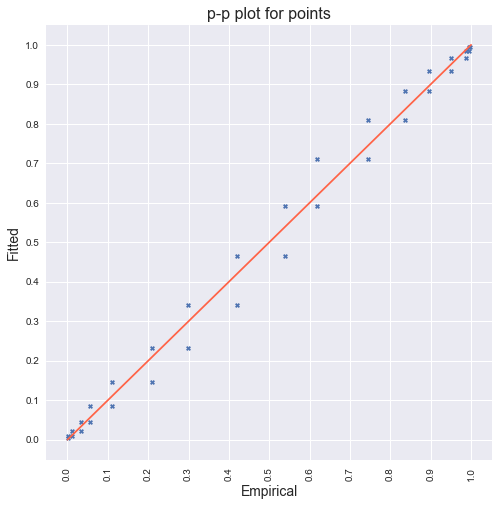

In [15]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

pp_df.plot(kind='scatter', x='F_i', y='p_fitted', ax=ax, marker='X')
forty_five_line_df.plot(kind='line', x='x', y='y', ax=ax, color='tomato')
ax.set_ylabel("Fitted", fontsize=14)
ax.set_xticks(np.arange(0, 1.02, 0.10))
ax.set_xticklabels(['%.1f' % f for f in np.arange(0, 1.1, 0.10)], rotation=90)
ax.set_yticks(np.arange(0, 1.02, 0.10))
ax.set_yticklabels(['%.1f' % f for f in np.arange(0, 1.1, 0.10)])
ax.set_xlabel("Empirical", fontsize=14)
ax.legend('')
ax.set_title("p-p plot for points", fontsize=16)
plt.show()

**Conclusion**: We can see that the fitted model is a fairly good fit because most of the values lie near the 45-degree line. However, the deviations start to be apparent where $0.4 \leq F \leq 0.6$.

### Diagnostic Tests - Kolmogorov-Smirnov Goodness of Fit Test

In [16]:
pp_df['D'] = (pp_df['F_i'] - pp_df['p_fitted']).abs()
pp_df['D'].max()

0.09245560874649605

For $\alpha=0.05$, the critical value is:

In [17]:
1.36/(empirical_groupby_df['cum_count'].max())**2

6.686299477387034e-06

And since calculated value of $D$ is much larger than the critical value, the null hypothesis that the normal is a good fit of the data is rejected. This supports the `pvalue` of the `kstest` result.

In [18]:
kstest(us_wines_df['points'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)